In [2]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize, downscale_local_mean
import math
import os
import numpy as np


import sigpy as sp
import sigpy.plot as pl
import seaborn as sns
from cmcrameri import cm

import sys
sys.path.append("/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from PIL import Image, ImageFilter
def get_edge(img):
    #define the vertical filter
    vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

    #get the dimensions of the image
    n,m = img.shape

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score*2

    #remap the values in the 0-1 range in case they went out of bounds
    edges_img = edges_img/edges_img.max()
    edges_img[edges_img ==0] = 'nan'
    edges_img[edges_img >0] = 1
    return edges_img

In [4]:
volunteer = 6#1 # volunteer

In [5]:
# Load in Spatial Gradients

inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Heart/V00' + str(volunteer) + '/DWI/'
savename = os.path.join(inpath,'M0_vgrad.npy')
vgrad = np.load(savename)
slope_m0 = np.sqrt(vgrad[0]**2 + vgrad[1]**2)

savename = os.path.join(inpath,'M1_vgrad.npy')
vgrad = np.load(savename)
slope_m1 = np.sqrt(vgrad[0]**2 + vgrad[1]**2)

savename = os.path.join(inpath,'M2_vgrad.npy')
vgrad = np.load(savename)
slope_m2 = np.sqrt(vgrad[0]**2 + vgrad[1]**2)

    

In [6]:
from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np

# inpath = '/Volumes/T7/phase_paper/Heart/V00' + volunteer + '/DWI'
inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Heart/V00' + str(volunteer) + '/DWI'

name = inpath.split('/')
namejoin = '/'.join(name[:-1])

nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
nii_files.sort()
bval_files.sort()
bvec_files.sort()


mask_files_LV = [_ for _ in os.listdir(inpath) if _.startswith('LV')]
mask_files_BP = [_ for _ in os.listdir(inpath) if _.startswith('BP')]

mask_files_LV.sort()
mask_files_BP.sort()

mm = 0
for num in range(1,7,2):

# inpath = '/Volumes/T7/phase_paper/Heart/V00' + volunteer + '/DWI'
    data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
    bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
    bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
    
    mask_LV,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_LV[mm]), return_voxsize=True)
    mask_BP,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_BP[mm]), return_voxsize=True)

    data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)

    ims = data1
    mag = abs(ims)
    phs = np.angle(ims)
    
    mask_LV_rep = np.tile(mask_LV[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
    mask_BP_rep = np.tile(mask_BP[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
    mask_rep = (mask_LV_rep - mask_BP_rep).astype(np.float32)
    
    mask_rep[mask_rep ==0] = np.nan
    adc_avg = DWI_recon(mag,bvals_sort,bvecs_sort)
    
    
    im = np.exp(1j*phs)
    
    
    if mag.shape[0] == 100:
        print('Dim',vv)
        mag = mag.transpose(1,0,2,3,4)
        phs = phs.transpose(1,0,2,3,4)
        mask_rep = mask_rep.transpose(1,0,2,3,4)
        adc_avg[0]['ADC'] = adc_avg[0]['ADC'].transpose(1,0,2)

    
    if num == 1:
        M0_mag = mag #* mask_rep
        M0_phs= phs #*mask_rep
        M0_mask = mask_rep #*mask_rep

    if num == 3:
        M1_mag = mag #* mask_rep
        M1_phs = phs #*mask_rep
        M1_mask = mask_rep #*mask_rep
 
    if num == 5:
        M2_mag= mag #* mask_rep
        M2_phs = phs #*mask_rep
        M2_mask = mask_rep #*mask_rep
        
    mm = mm +1


/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: divide by zero encountered in divide
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: invalid value encountered in divide
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate

In [7]:
slope_m0.shape

(128, 100, 3, 4, 5)

In [8]:
# Calculate STD
M0_adj = slope_m0
M1_adj = slope_m1
M2_adj = slope_m2

M0_diff = M0_adj - np.nanmean(M0_adj,axis = -1)[:,:,:,:,np.newaxis]
M1_diff= M1_adj - np.nanmean(M1_adj,axis = -1)[:,:,:,:,np.newaxis]
M2_diff= M2_adj - np.nanmean(M2_adj,axis = -1)[:,:,:,:,np.newaxis]

M0_std = np.nanstd(slope_m0,axis = -1)#np.sqrt(np.sum((M0_diff)**2,axis = -2)/5)
M1_std = np.nanstd(slope_m1,axis = -1)#np.sqrt(np.sum((M1_diff)**2,axis = -2)/5)
M2_std = np.nanstd(slope_m2,axis = -1)#np.sqrt(np.sum((M2_diff)**2,axis = -2)/5)




<ipython-input-8-7a58ebf33718>:6: RuntimeWarning: Mean of empty slice
  M0_diff = M0_adj - np.nanmean(M0_adj,axis = -1)[:,:,:,:,np.newaxis]
<ipython-input-8-7a58ebf33718>:7: RuntimeWarning: Mean of empty slice
  M1_diff= M1_adj - np.nanmean(M1_adj,axis = -1)[:,:,:,:,np.newaxis]
<ipython-input-8-7a58ebf33718>:8: RuntimeWarning: Mean of empty slice
  M2_diff= M2_adj - np.nanmean(M2_adj,axis = -1)[:,:,:,:,np.newaxis]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<ipython-input-9-d8992e710391>:24: RuntimeWarning: Mean of empty slice
  phs_m0 = (np.nanmean(slope_m0,axis = -1)[:,:,:,:,np.newaxis]) * M0_mask
<ipython-input-9-d8992e710391>:25: RuntimeWarning: Mean of empty slice
  phs_m1 =  (np.nanmean(slope_m1,axis = -1)[:,:,:,:,np.newaxis]) * M1_mask
<ipython-input-9-d8992e710391>:26: RuntimeWarning: Mean of empty slice
  phs_m2 =  (np.nanmean(slope_m2,axis = -1)[:,:,:,:,np.newaxis])* M2_mask


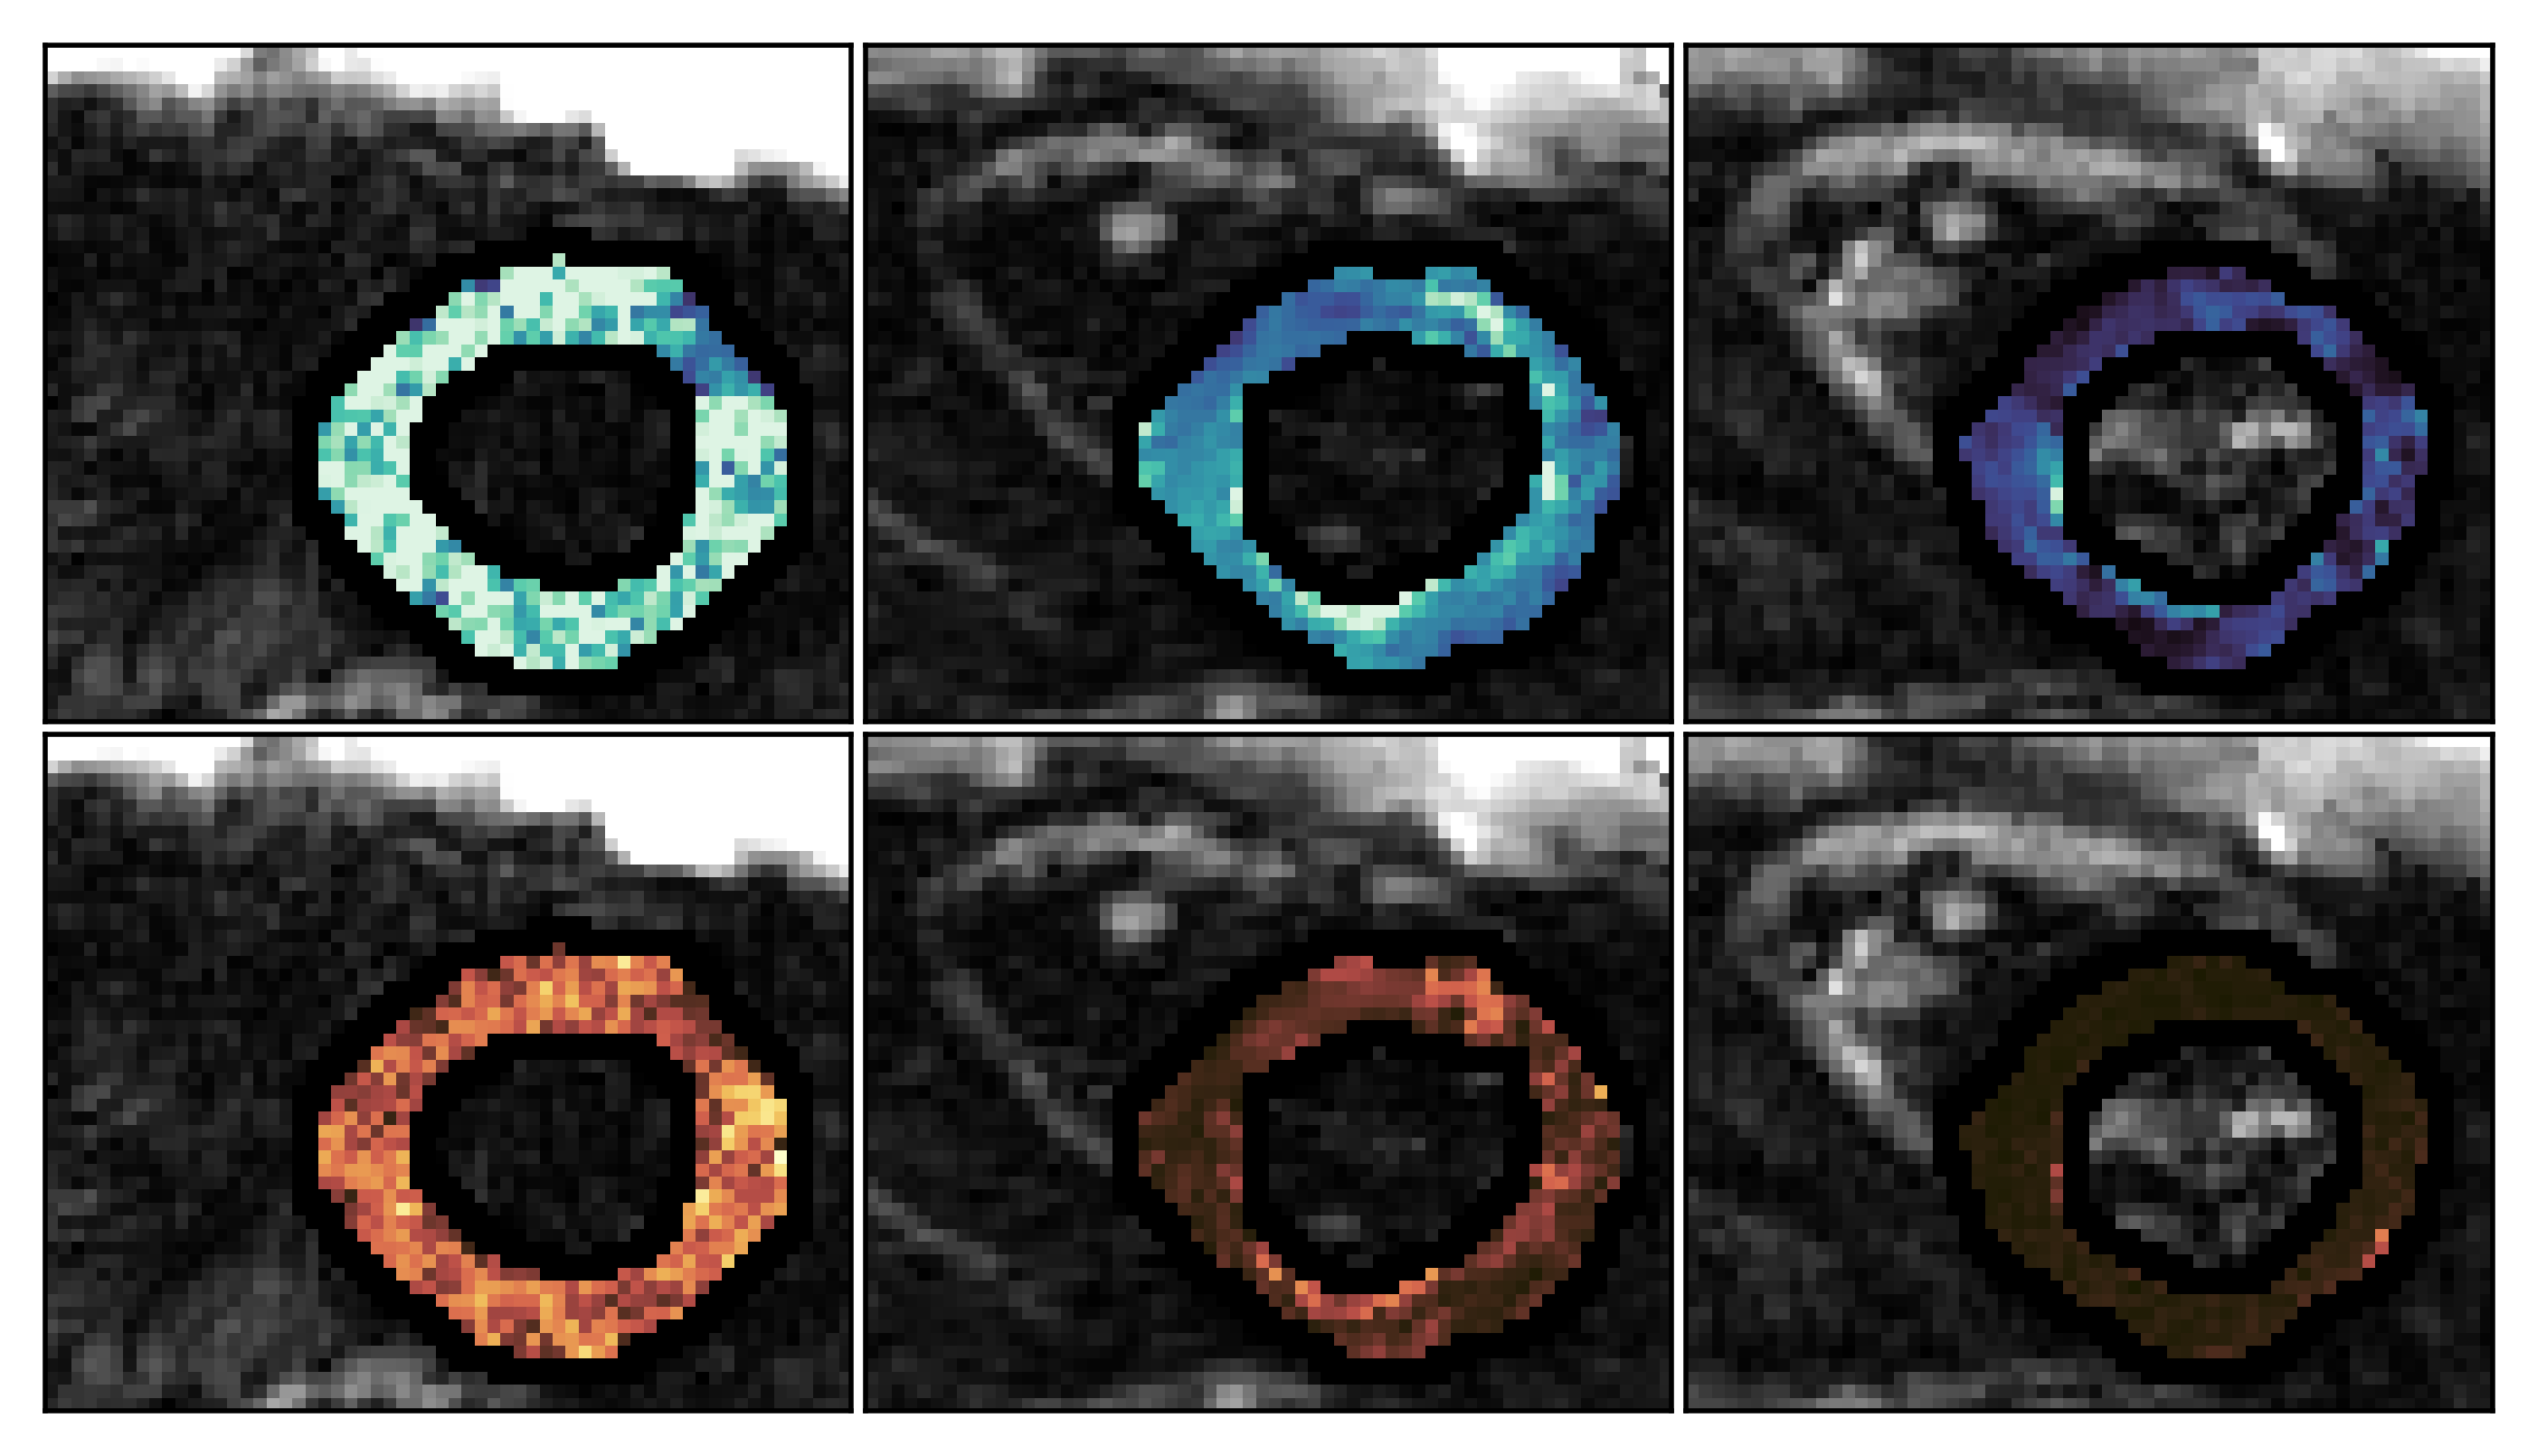

In [9]:
sl = 1
diffusion = -1 # diffusion direction [0, X [1], Y[2], Z[3]]
rep = -2

fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(7,4), dpi=500)

w1 = 18
w2 = 70
l1= 13
l2 = 75

### Get magnitude images
for ii in range(2):
    axes[ii,0].imshow(abs(M0_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')
    axes[ii,1].imshow(abs(M1_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')
    im0=axes[ii,2].imshow(abs(M2_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')




color = color = sns.color_palette("mako",as_cmap = True)
######### mean
row = 0
phs_m0 = (np.nanmean(slope_m0,axis = -1)[:,:,:,:,np.newaxis]) * M0_mask
phs_m1 =  (np.nanmean(slope_m1,axis = -1)[:,:,:,:,np.newaxis]) * M1_mask
phs_m2 =  (np.nanmean(slope_m2,axis = -1)[:,:,:,:,np.newaxis])* M2_mask
axes[row,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[row,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,0],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
im4=axes[row,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,0],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[row,0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,diffusion,0])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')






color = cm.lajolla_r
######### STandard Deviation 
row = 1
phs_m0 = (M0_std[:,:,:,:,np.newaxis]) * M0_mask
phs_m1 = (M1_std[:,:,:,:,np.newaxis]) * M1_mask
phs_m2 = (M2_std[:,:,:,:,np.newaxis]) * M2_mask
axes[row,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[row,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,0],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
im4=axes[row,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,0],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[row,0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,diffusion,0])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')



for j in range(3):
    for m in range(2):
        axes[m,j].get_xaxis().set_ticks([])
        axes[m,j].get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=0.01, hspace=0.02)   
plt.show()

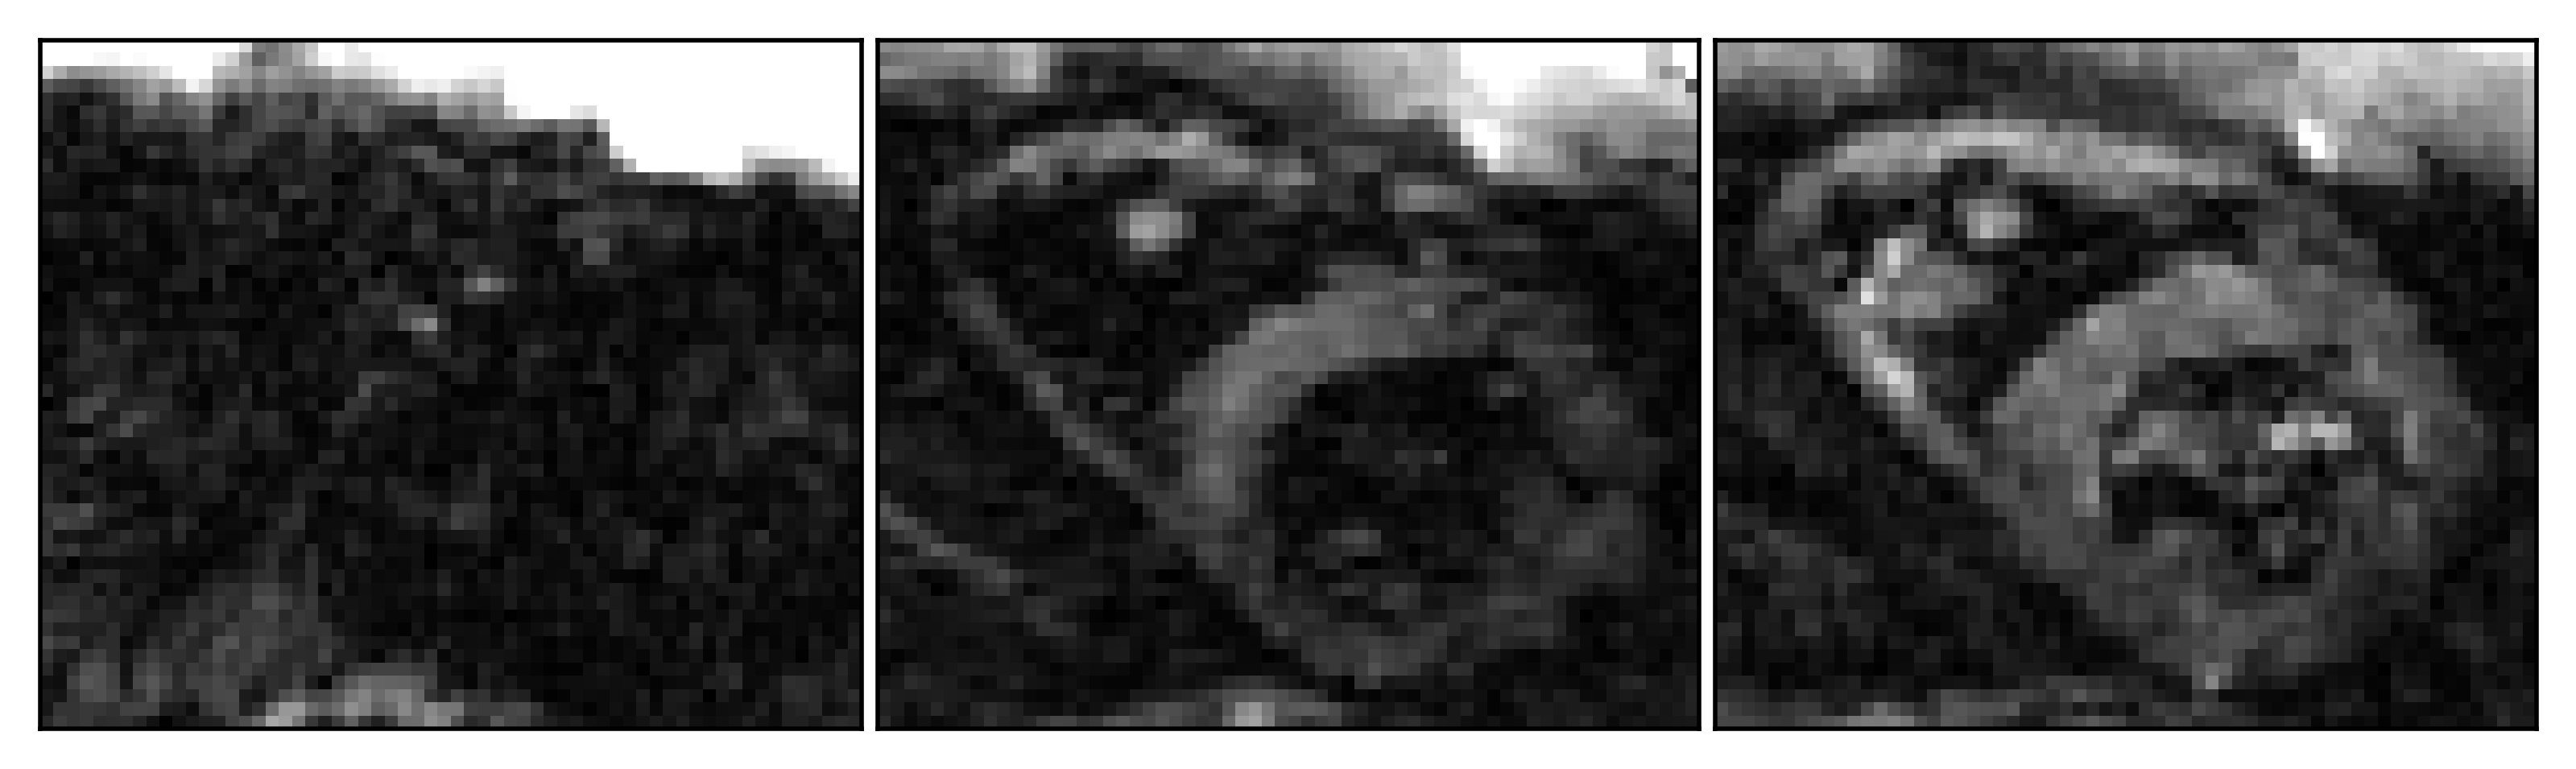

In [14]:
# Horizontal Fig 
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(8,6), dpi=500)

w1 = 18
w2 = 70
l1= 13
l2 = 75

color = 'gray'
vmax = 100

axes[0].imshow(abs(M0_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')
axes[1].imshow(abs(M1_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')
im0=axes[2].imshow(abs(M2_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')


for j in range(3):
    axes[j].get_xaxis().set_ticks([])
    axes[j].get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=0.02, hspace=0.01)   

<ipython-input-16-7edfa3ec7de9>:21: RuntimeWarning: Mean of empty slice
  phs_m0 = (np.nanmean(slope_m0,axis = -1)[:,:,:,:,np.newaxis]) * M0_mask
<ipython-input-16-7edfa3ec7de9>:22: RuntimeWarning: Mean of empty slice
  phs_m1 =  (np.nanmean(slope_m1,axis = -1)[:,:,:,:,np.newaxis]) * M1_mask
<ipython-input-16-7edfa3ec7de9>:23: RuntimeWarning: Mean of empty slice
  phs_m2 =  (np.nanmean(slope_m2,axis = -1)[:,:,:,:,np.newaxis])* M2_mask


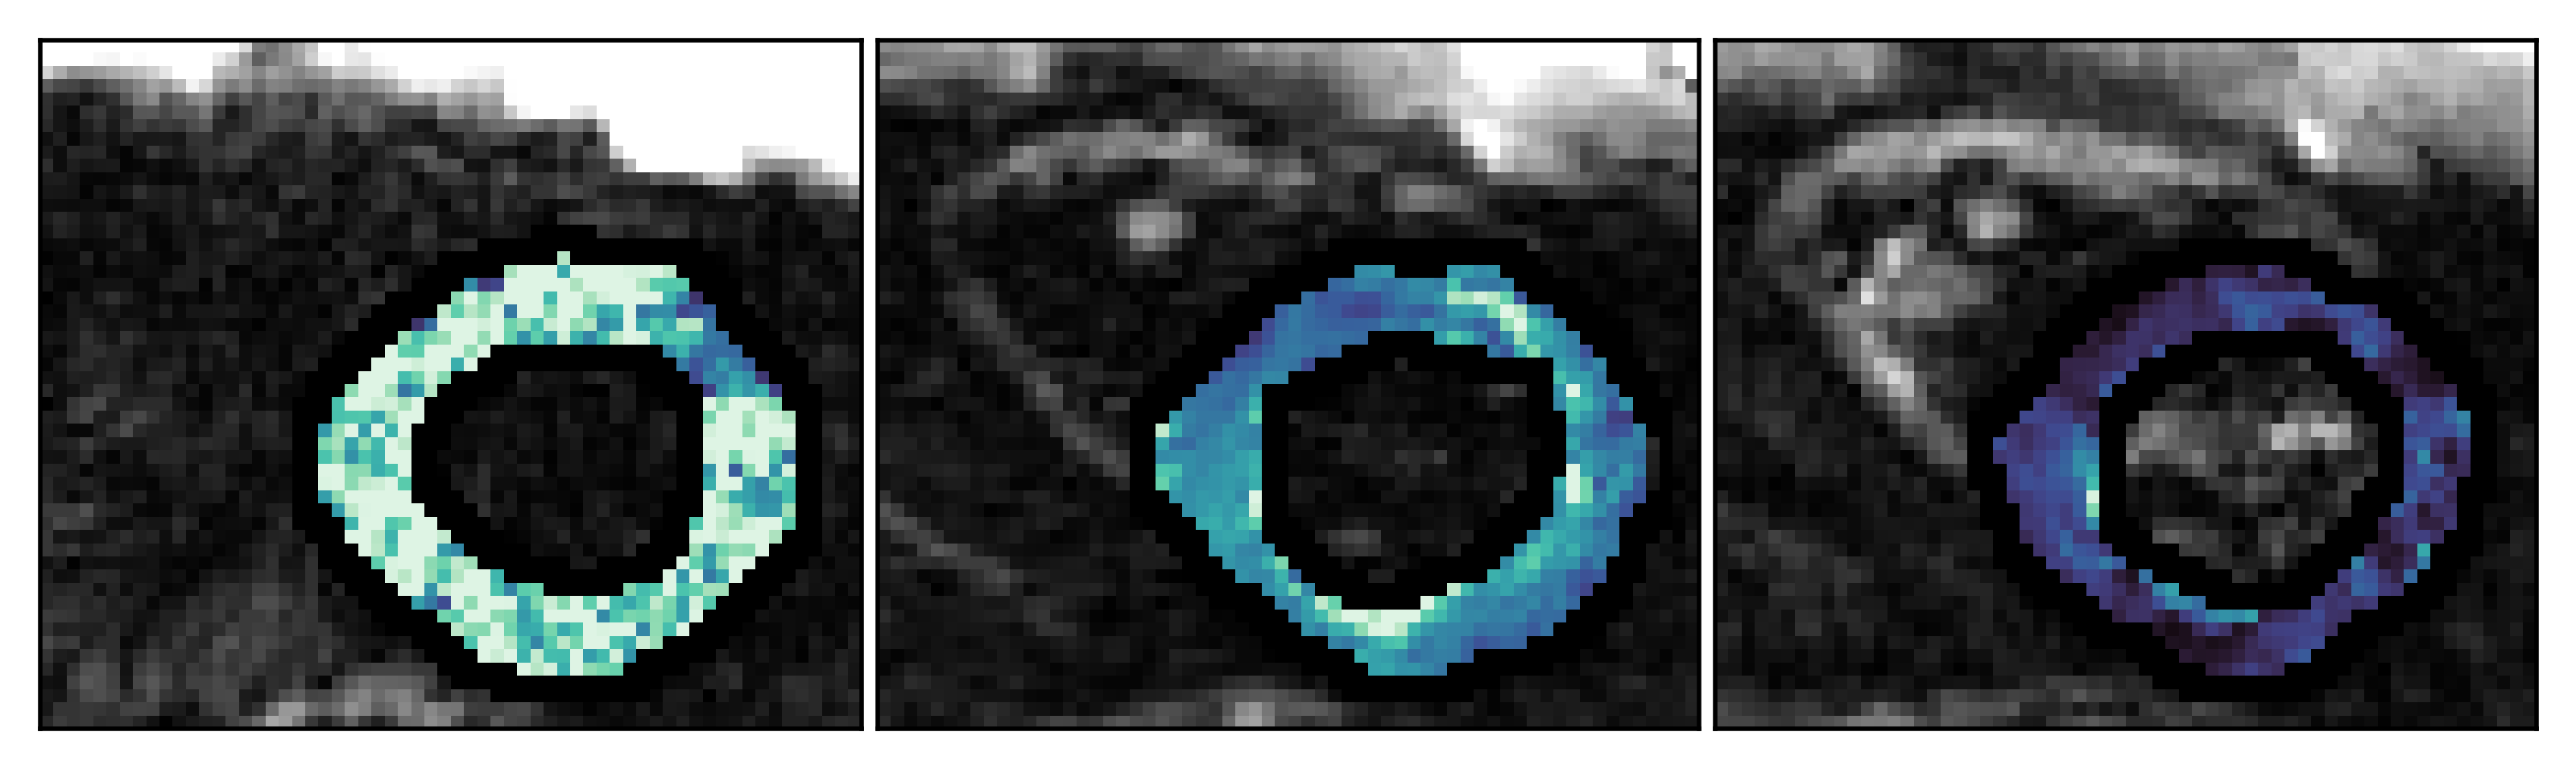

In [16]:
# Horizontal Fig 
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(8,6), dpi=500)

w1 = 18
w2 = 70
l1= 13
l2 = 75

color = 'gray'
vmax = 100

axes[0].imshow(abs(M0_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')
axes[1].imshow(abs(M1_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')
im0=axes[2].imshow(abs(M2_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')



color = color = sns.color_palette("mako",as_cmap = True)
######### mean
row = 0
phs_m0 = (np.nanmean(slope_m0,axis = -1)[:,:,:,:,np.newaxis]) * M0_mask
phs_m1 =  (np.nanmean(slope_m1,axis = -1)[:,:,:,:,np.newaxis]) * M1_mask
phs_m2 =  (np.nanmean(slope_m2,axis = -1)[:,:,:,:,np.newaxis])* M2_mask
axes[0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,0],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
im4=axes[2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,0],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,diffusion,0])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')


for j in range(3):
    axes[j].get_xaxis().set_ticks([])
    axes[j].get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=0.02, hspace=0.01)   
